In [1]:
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = "/content/drive/Shareddrives/Big_DATA/DataCoSupplyChainDataset.csv"

In [5]:
import pandas as pd
# Load the dataset
data = pd.read_csv(file_path,encoding='latin-1')
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [6]:

pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=67946514b52e6be78ed6f6c606e7aa313ea64cb778c2058f66eaf3beb4f4453b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, count, when, to_timestamp,to_date,skewness
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType, NumericType
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
from pyspark.sql.functions import year, month, dayofmonth, monotonically_increasing_id
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SupplyChainOptimization').config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)


In [9]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

**Handling Missing Values**

In [10]:
# Calculating null counts for each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# To sort and transpose, additional steps are needed because PySpark does not directly support transposing:
# Convert the Row type into a dictionary, sort it, and then parallelize to create a new DataFrame
sorted_null_counts = sorted(null_counts.collect()[0].asDict().items(), key=lambda x: x[1], reverse=True)

# Create a new DataFrame from sorted values for transposition
new_df = spark.createDataFrame([sorted_null_counts], schema=["Column", "Count"])

# Since direct transposition isn't feasible in PySpark like in pandas, we handle the transpose manually
# Creating a DataFrame with one column per original column with their respective null count
transposed_df = spark.createDataFrame([(k, v) for k, v in sorted_null_counts], ['Column', 'Null Count'])

# Show the result
transposed_df.show()

+--------------------+----------+
|              Column|Null Count|
+--------------------+----------+
| Product Description|    180519|
|       Order Zipcode|    155679|
|      Customer Lname|         8|
|    Customer Zipcode|         3|
|                Type|         0|
|Days for shipping...|         0|
|Days for shipment...|         0|
|   Benefit per order|         0|
|  Sales per customer|         0|
|     Delivery Status|         0|
|  Late_delivery_risk|         0|
|         Category Id|         0|
|       Category Name|         0|
|       Customer City|         0|
|    Customer Country|         0|
|      Customer Email|         0|
|      Customer Fname|         0|
|         Customer Id|         0|
|   Customer Password|         0|
|    Customer Segment|         0|
+--------------------+----------+
only showing top 20 rows



**Dropping Columns**

In [11]:

# List of columns to be dropped
drop_cols = ['Product Description', 'Order Zipcode', "Product Image", "Customer Email", "Customer Fname",
             "Customer Lname", "Customer Password", "Customer Street"]

# Dropping the columns from the DataFrame
df = df.drop(*drop_cols)


In [12]:

# List of columns to be dropped
drop_cols = ['Market', 'Product Name', 'Order Id', 'Customer State',
             'Customer City', 'Customer Country', 'Customer Id', 'Order Region']

# Dropping the columns from the DataFrame
df = df.drop(*drop_cols)


Dropping because

Customer Id and Order Id doesn't contain extra information

Customer Zipcode can be used instead of 'Customer State', 'Category Name', 'Customer City', 'Customer Country'

Order Region doesn't provide extra information

In [13]:

df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+----------------+----------------+-------------+---------------+-----------+------------+----------+-------------+-----------------+-----------------------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------------+---------------+---------------+-------------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer Segment|Customer Zipcode|Department Id|Department Name|   Latitude|   Longitude|Order City|Order Country|Order Customer Id|order date (DateOrders)|Order Item Ca

**Change DType**

In [14]:
date_cols = ['order date (DateOrders)', 'shipping date (DateOrders)']

# Convert date columns to timestamps
for col_name in date_cols:
    df = df.withColumn(col_name, to_timestamp(col_name, "MM/dd/yyyy HH:mm"))

# Show the DataFrame with converted timestamp columns
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+----------------+----------------+-------------+---------------+-----------+------------+----------+-------------+-----------------+-----------------------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------------+---------------+---------------+-------------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer Segment|Customer Zipcode|Department Id|Department Name|   Latitude|   Longitude|Order City|Order Country|Order Customer Id|order date (DateOrders)|Order Item Ca

**Features**

In [15]:
# Get the schema of the DataFrame
schema = dict(df.dtypes)

# Separate numerical and categorical columns based on data type
numerical_cols = [k for k, v in schema.items() if v in ('int', 'double', 'float', 'bigint', 'long')]
categorical_cols = [k for k, v in schema.items() if v == 'string']

print("Numerical Features: ", numerical_cols)
print()
print("Categorical Features: ", categorical_cols)

Numerical Features:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Card Id', 'Product Category Id', 'Product Price', 'Product Status']

Categorical Features:  ['Type', 'Delivery Status', 'Category Name', 'Customer Segment', 'Department Name', 'Order City', 'Order Country', 'Order State', 'Order Status', 'Shipping Mode']





**skewness**

In [16]:
# Calculate skewness for each numerical column
skewness_df = df.select([skewness(col(c)).alias(c) for c in numerical_cols])

# Since skewness_df results in a single row DataFrame with each column representing skewness of the original columns,
# we need to convert this to a format that can be sorted (like turning it into a two-column DataFrame of column names and skewness values)
skew_list = [(c, skewness_df.collect()[0][c]) for c in numerical_cols]

# Convert list to DataFrame
skew_df = spark.createDataFrame(skew_list, ["Column", "Skewness"])

# Sort by skewness
sorted_skew_df = skew_df.orderBy("Skewness")

In [17]:
sorted_skew_df.show()

+--------------------+--------------------+
|              Column|            Skewness|
+--------------------+--------------------+
|      Product Status|                NULL|
|   Benefit per order|  -4.741794668497194|
|Order Profit Per ...|  -4.741794668497194|
|Order Item Profit...|  -2.893507297632773|
|Days for shipment...| -0.7319922017554492|
|           Longitude| -0.4984569306582679|
|  Late_delivery_risk|-0.19407255746462226|
|            Latitude|-0.09796185221945793|
|       Order Item Id|6.989793896425066...|
|Days for shipping...| 0.08477056859739367|
|     Product Card Id|  0.1382534611130587|
|Order Item Cardpr...|  0.1382534611130587|
|       Department Id| 0.27331835800505905|
|Order Item Discou...|     0.3409247682746|
|         Category Id|  0.3616217945111838|
| Product Category Id|  0.3616217945111838|
|   Order Customer Id|  0.4887641901446368|
|    Customer Zipcode| 0.49087933052577337|
| Order Item Quantity|  0.8802445335313527|
|               Sales|   2.88422

In [18]:
unique_counts = []

# Calculate unique counts for each categorical column
for col_name in categorical_cols:
    unique_count = df.agg(countDistinct(col(col_name)).alias("unique_count")).collect()[0]["unique_count"]
    unique_counts.append(Row(Column=col_name, Unique_Count=unique_count))

# Convert list to DataFrame
unique_df = spark.createDataFrame(unique_counts)
sorted_unique_df = unique_df.orderBy("Unique_Count")
sorted_unique_df.show()

+----------------+------------+
|          Column|Unique_Count|
+----------------+------------+
|Customer Segment|           3|
|   Shipping Mode|           4|
|            Type|           4|
| Delivery Status|           4|
|    Order Status|           9|
| Department Name|          11|
|   Category Name|          50|
|   Order Country|         164|
|     Order State|        1089|
|      Order City|        3597|
+----------------+------------+



In [19]:
df = df.dropna(subset=numerical_cols)

In [20]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- Order Customer Id: integer (nullable = true)
 |-- order date (DateOrders): timestamp (nullable = true)
 |-- Order Item Cardprod Id: integer (nullable = true)
 |-- Order Item Discount: double 

Hypothesis

#  Multiple Hypotheses Scenario:

```
1. Hypothesis 1: "Geographical information like 'Order City' and 'Order Country' significantly affect delivery status and promptness, with certain locations consistently experiencing more late deliveries due to logistical challenges."

```



In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, sum as sum_, desc

# Start a Spark session
spark = SparkSession.builder.appName("Delivery Ratio Analysis").getOrCreate()

# Assuming 'df' is your DataFrame that has already been loaded

# Add a column to mark late deliveries
df = df.withColumn("is_late", when(col("Days for shipping (real)") > col("Days for shipment (scheduled)"), 1).otherwise(0))

# Group by 'Order City' and 'Order Country'
delivery_stats = df.groupBy("Order City", "Order Country").agg(
    count("*").alias("total_deliveries"),
    sum_("is_late").alias("late_deliveries")
)

# Calculate the proportion of late deliveries
delivery_stats = delivery_stats.withColumn("late_delivery_rate", col("late_deliveries") / col("total_deliveries"))

# Sort by highest late delivery rate
highest_late_delivery = delivery_stats.orderBy(desc("late_delivery_rate"))

# Sort by lowest late delivery rate (excluding cities with zero late deliveries for meaningful comparison)
lowest_late_delivery = delivery_stats.filter(col("late_deliveries") > 0).orderBy("late_delivery_rate")

# Show the results for cities with the highest and lowest late delivery rates
print("Cities with the Highest Late Delivery Rates:")
highest_late_delivery.show()

print("Cities with the Lowest Late Delivery Rates:")
lowest_late_delivery.show()

# Stop the Spark session

Cities with the Highest Late Delivery Rates:
+----------------+--------------+----------------+---------------+------------------+
|      Order City| Order Country|total_deliveries|late_deliveries|late_delivery_rate|
+----------------+--------------+----------------+---------------+------------------+
|         Kwangju| Corea del Sur|               7|              7|               1.0|
|     Birobidzhan|         Rusia|               3|              3|               1.0|
|          Mutare|      Zimbabue|               5|              5|               1.0|
|          Maxixe|    Mozambique|               2|              2|               1.0|
|North Charleston|Estados Unidos|               7|              7|               1.0|
|    Peterborough|        Canada|               5|              5|               1.0|
|    Valenciennes|       Francia|               5|              5|               1.0|
|     Dzhezkazgan|    Kazajist�n|               5|              5|               1.0|
|       B

The results provide a clear contrast between cities with the highest and lowest late delivery rates:

Cities with the Highest Late Delivery Rates:
These cities, including places like Kwangju (South Korea), Birobidzhan (Russia), and Sparks (USA), have late delivery rates of 100%. This suggests that every recorded delivery in these locations was late, indicating significant logistical challenges or issues in these areas.

Cities with the Lowest Late Delivery Rates:
Conversely, cities like Gradignan (France), Itapecuru Mirim (Brazil), and Clarksville (USA) show very low late delivery rates (below 5%). These cities are managing their deliveries much more effectively, with very few deliveries being late compared to their total deliveries.

Analysis and Recommendations:

For cities with high late delivery rates, it might be valuable to conduct further investigations to understand the specific causes—whether they are related to logistical issues, geographical challenges, or perhaps systemic delays in certain shipping modes or routes.
For cities with low late delivery rates, it would be beneficial to study their logistics and delivery methods to identify best practices and strategies that could potentially be applied to improve performance in areas with higher rates of late deliveries.


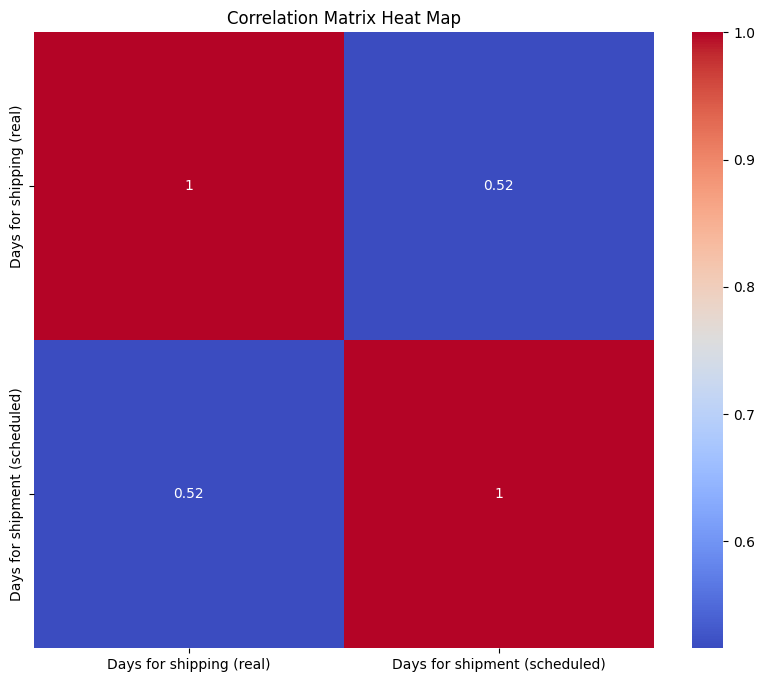

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame that has been loaded with appropriate data

# Specify the columns you want to include in the correlation matrix
columns_to_correlate = ["Days for shipping (real)", "Days for shipment (scheduled)"]

# Convert to vector column first
assembler = VectorAssembler(inputCols=columns_to_correlate, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Get correlation matrix
matrix = Correlation.corr(df_vector, "features").head()

# Extract the correlation matrix as a numpy array
correlation_matrix = matrix[0].toArray()

# Convert to pandas DataFrame for better visualization
corr_df = pd.DataFrame(correlation_matrix, columns=columns_to_correlate, index=columns_to_correlate)

# Plotting the heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heat Map')
plt.show()


In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg

# Assuming 'df' is your DataFrame already loaded with the appropriate data

# Add a column to mark late deliveries
df = df.withColumn("is_late", when(col("Days for shipping (real)") > col("Days for shipment (scheduled)"), 1).otherwise(0))

# Group by 'Order City' and 'Order Country' and calculate metrics
city_country_stats = df.groupBy("Order City", "Order Country").agg(
    avg("is_late").alias("avg_late_delivery"),
    avg("Days for shipping (real)").alias("avg_real_shipping_days"),
    avg("Days for shipment (scheduled)").alias("avg_scheduled_shipping_days")
)


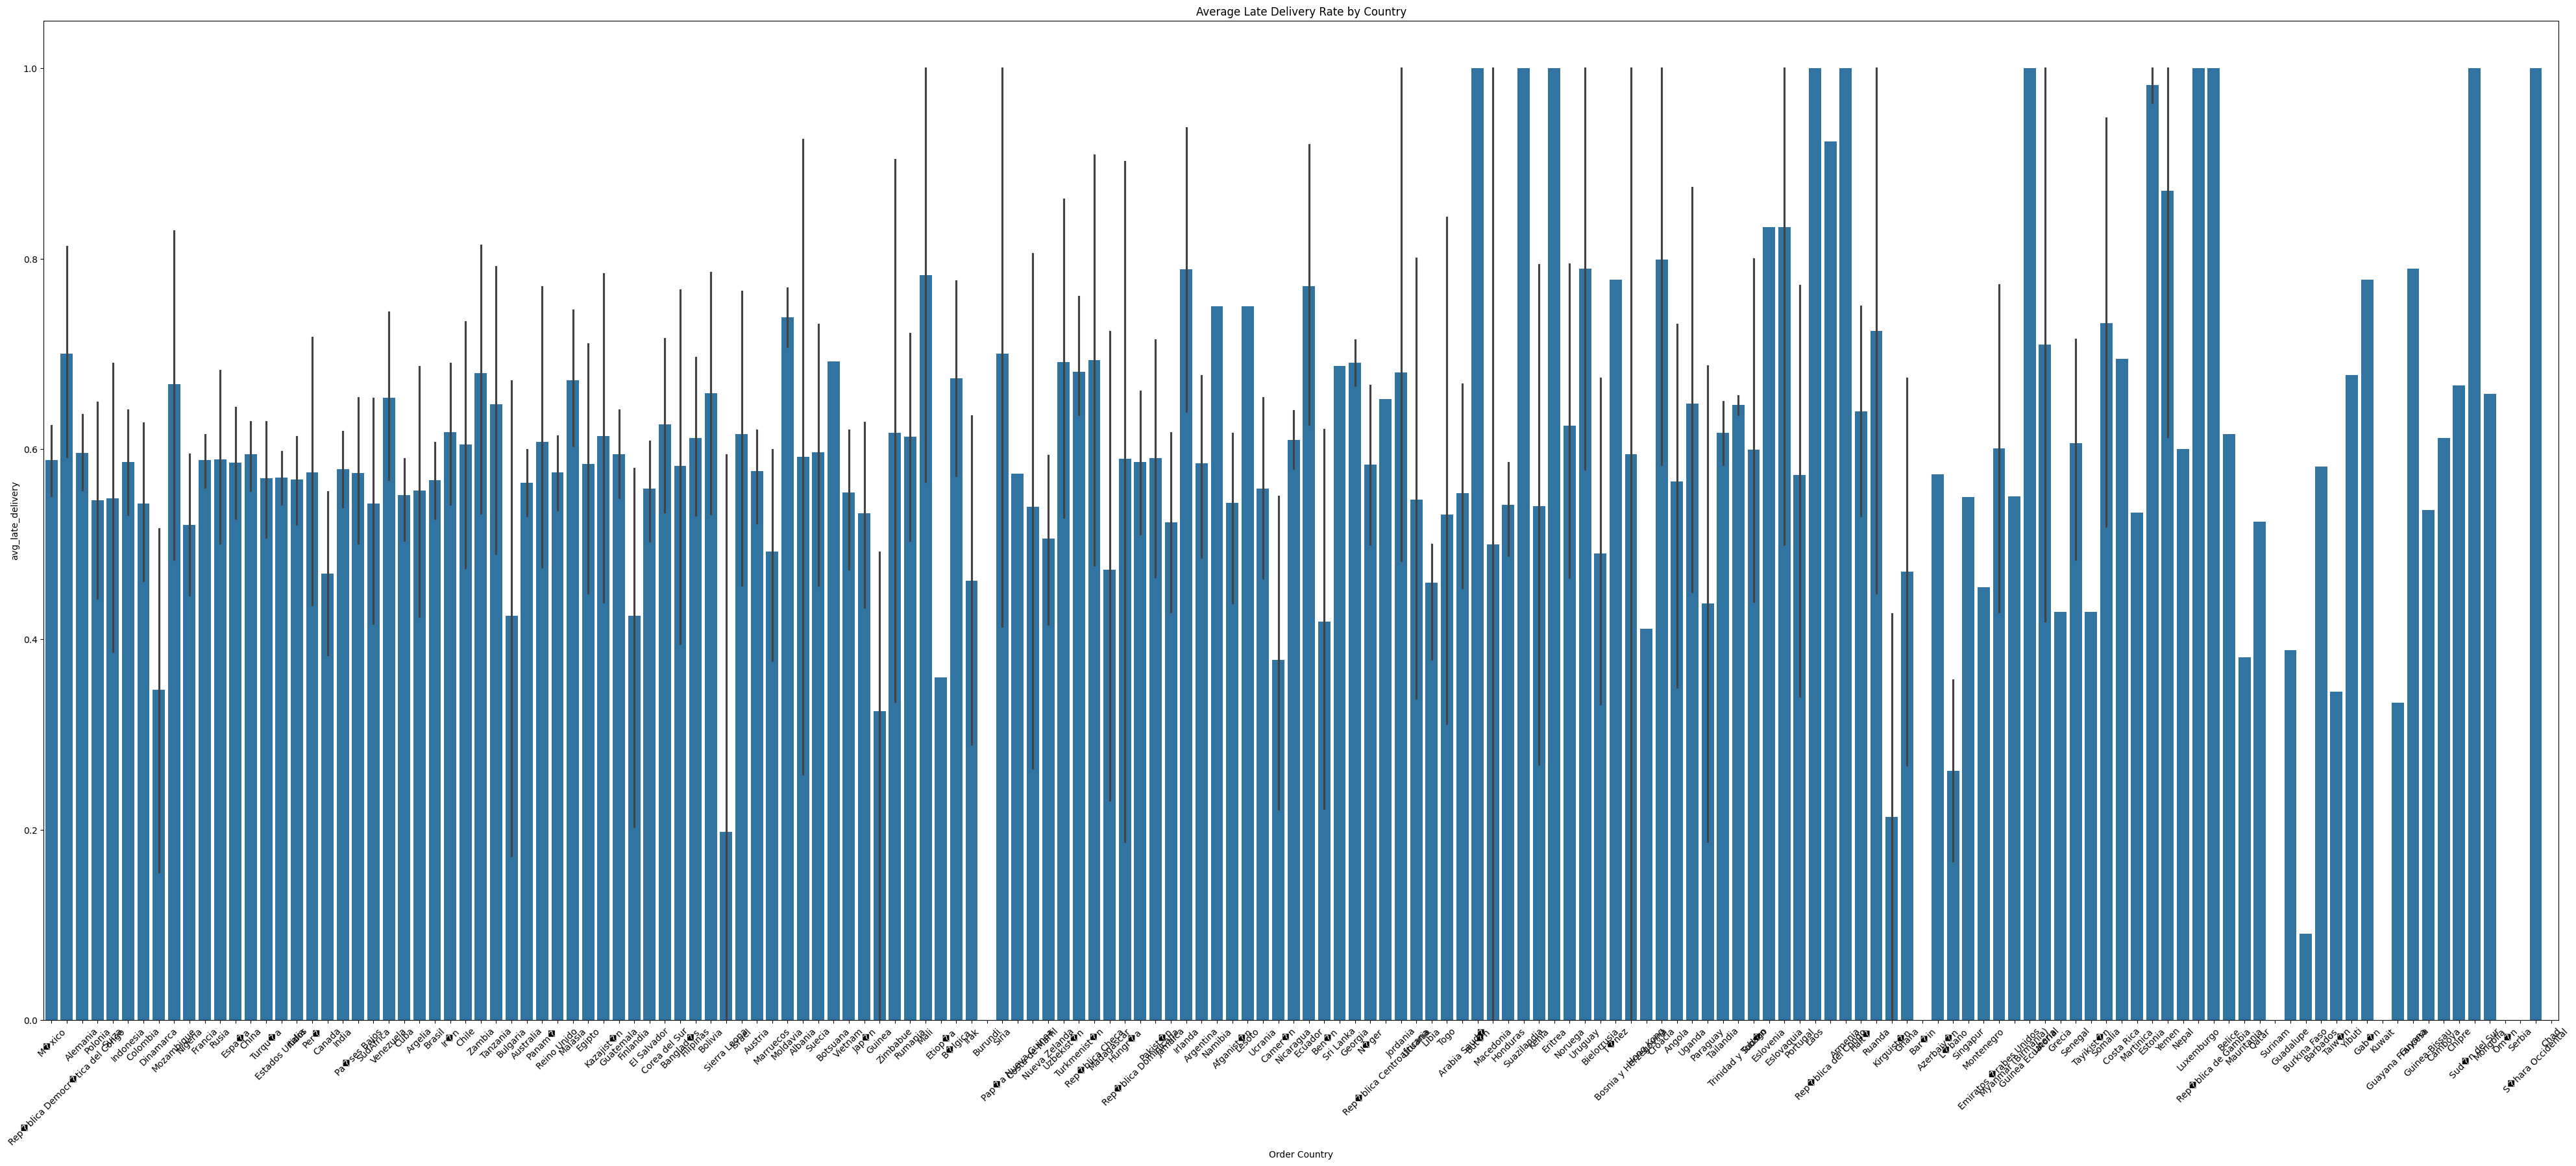

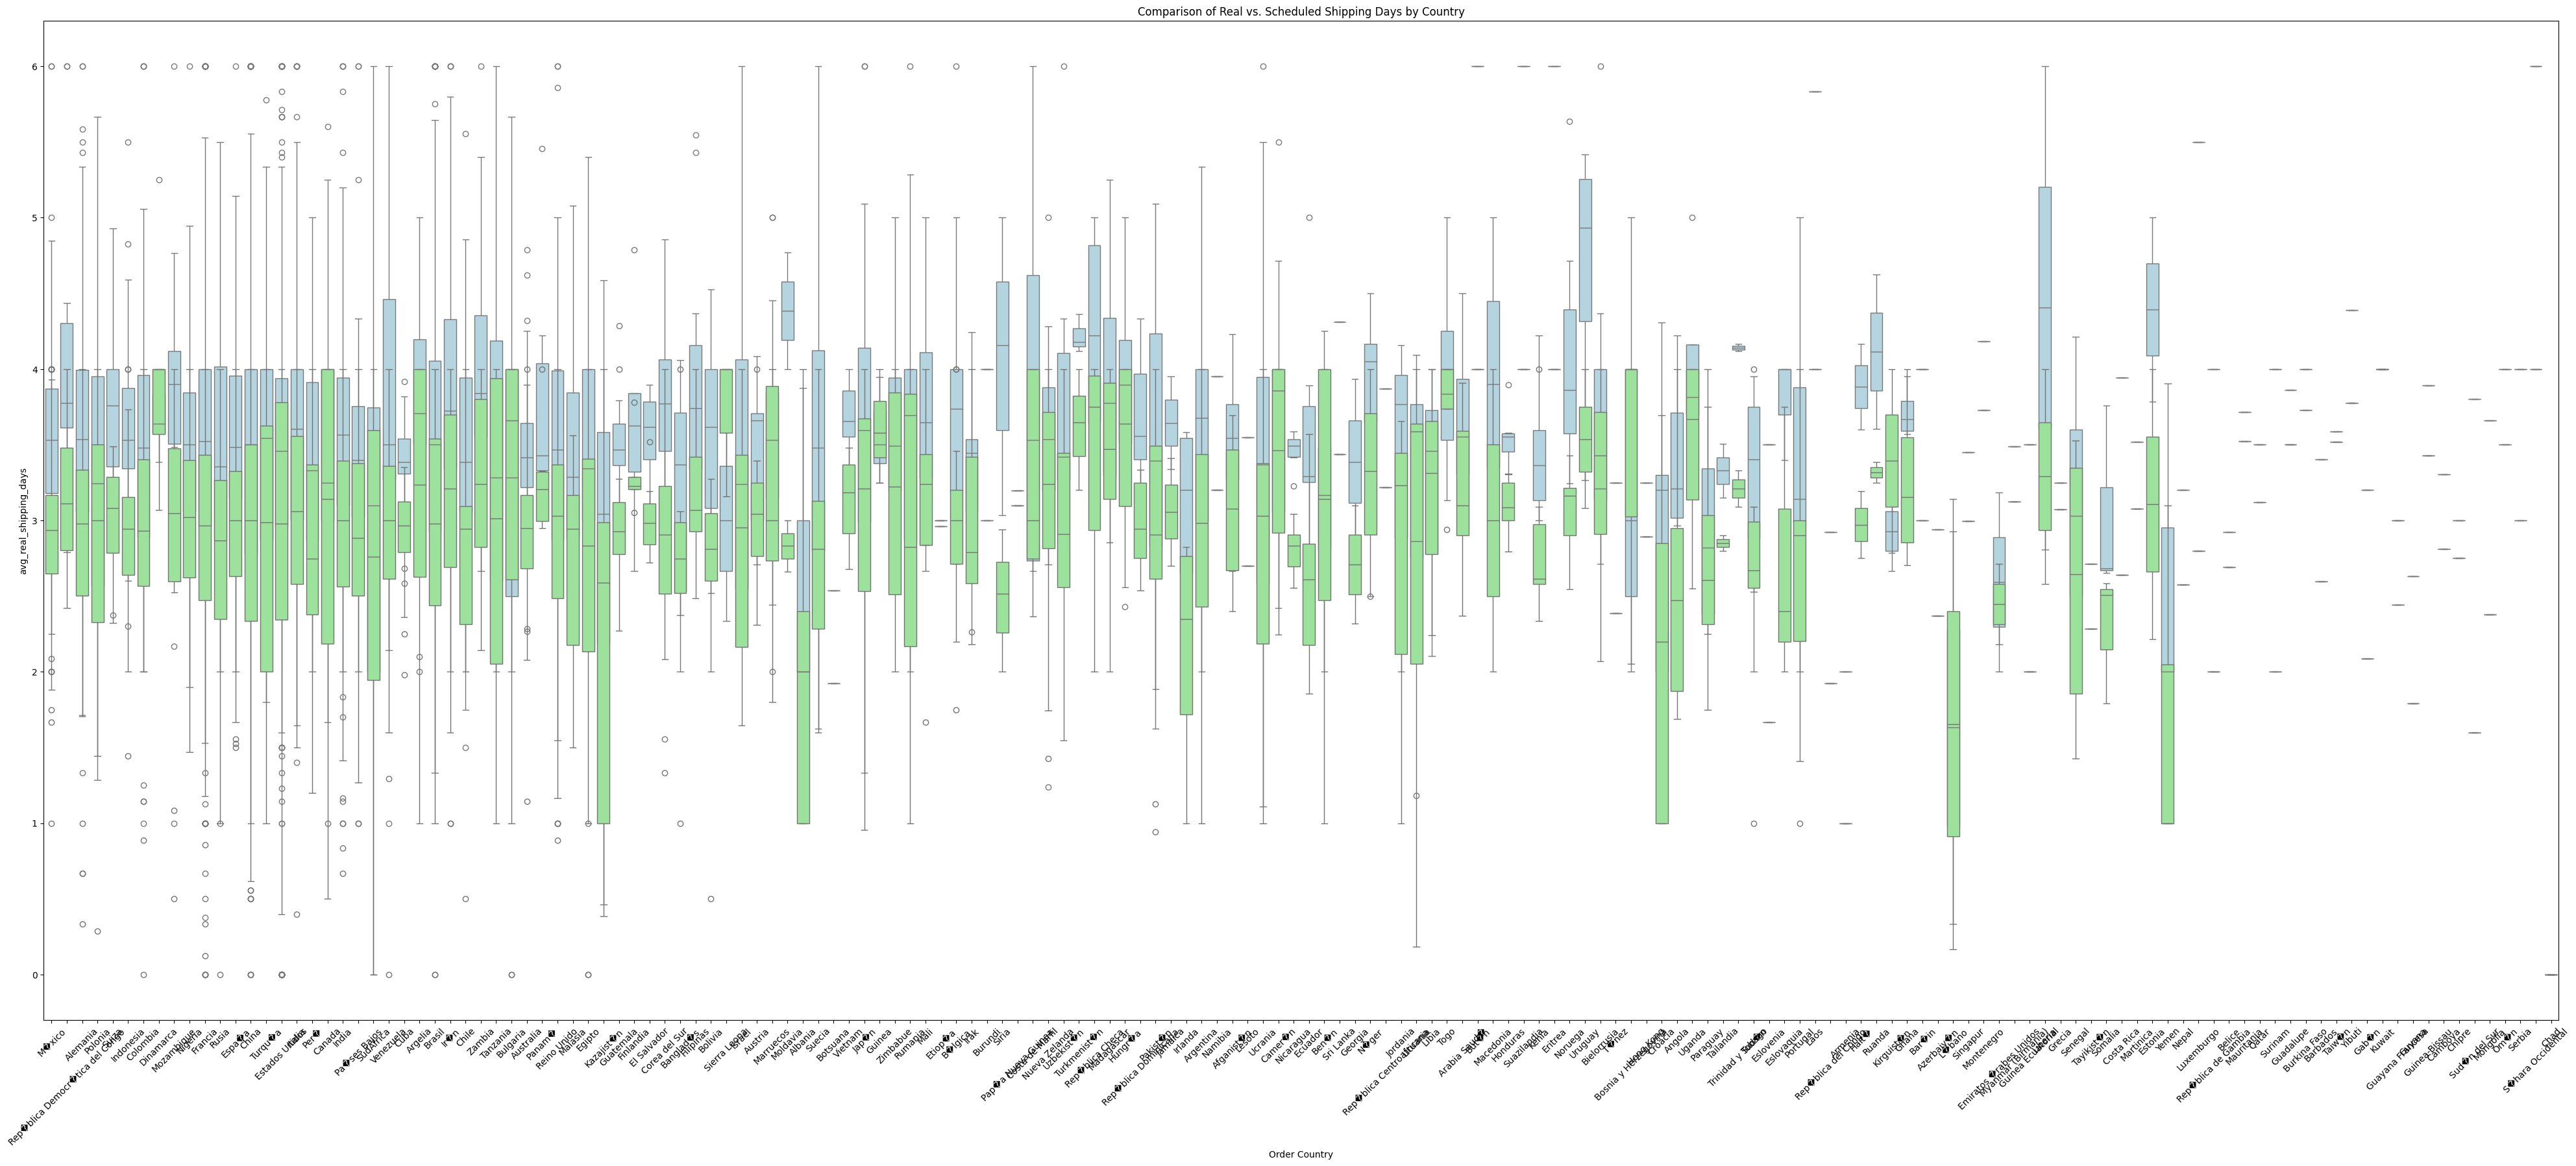

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame
city_country_stats_pd = city_country_stats.toPandas()

# Plotting Late Delivery Rates by Country
plt.figure(figsize=(50,20))
sns.barplot(x="Order Country", y="avg_late_delivery", data=city_country_stats_pd)
plt.title('Average Late Delivery Rate by Country')
plt.xticks(rotation=45)
plt.show()

# Box Plot for Real vs. Scheduled Shipping Days by Country
plt.figure(figsize=(50,20))
sns.boxplot(x="Order Country", y="avg_real_shipping_days", data=city_country_stats_pd, color='lightblue')
sns.boxplot(x="Order Country", y="avg_scheduled_shipping_days", data=city_country_stats_pd, color='lightgreen')
plt.title('Comparison of Real vs. Scheduled Shipping Days by Country')
plt.xticks(rotation=45)
plt.show()


Average Late Delivery Rate by Country (Bar Chart)

Chart Overview: The bar chart displays the average late delivery rate for each country. The height of each bar indicates the proportion of late deliveries in that country, which can give an indication of how well deliveries are managed within that geographic location.
Key Observations: This visualization shows significant variability between countries in terms of late delivery rates. Countries with very high rates may be experiencing systemic issues or inefficiencies in their delivery systems.


Comparison of Real vs. Scheduled Shipping Days by Country (Box Plot)

Chart Overview: The box plots compare the actual shipping days to the scheduled shipping days for each country. This visual representation shows the distribution of shipping days, highlighting the median, quartiles, and outliers.
Key Observations: Some countries consistently exceed their scheduled shipping days (where the blue box is higher than the green), which can indicate logistical challenges or inefficiencies. The spread and outliers in the box plots also give insights into the consistency and reliability of shipping operations in each country.

Outliers Above the Box: Longer-than-expected shipping times. These might indicate delays caused by logistical challenges, regulatory issues, or other disruptions in those specific instances.
Outliers Below the Box: Shorter-than-expected shipping times. These might indicate cases where the logistics were exceptionally efficient, or perhaps fewer issues were encountered than normally expected.

Support for Hypothesis: Both charts indicate that geographical factors ('Order Country') significantly impact delivery times and the rate of late deliveries. This supports your hypothesis that geographical information like 'Order City' and 'Order Country' significantly affects delivery status and promptness.

Hypothesis 2: "The 'Shipping Mode' which was chosen has a considerable effect on the delivery status, with faster, more costlier shipping options results in on-time delivery more often than compared to other standard options."

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, sum as sum_, desc


# Assuming 'df' is your DataFrame that has already been loaded

# Add a column to mark late deliveries
df = df.withColumn("is_late", when(col("Days for shipping (real)") > col("Days for shipment (scheduled)"), 1).otherwise(0))

# Group by 'Shipping Mode'
shipping_mode_stats = df.groupBy("Shipping Mode").agg(
    count("*").alias("total_deliveries"),
    sum_("is_late").alias("late_deliveries")
)

# Calculate the proportion of late deliveries
shipping_mode_stats = shipping_mode_stats.withColumn("late_delivery_rate", col("late_deliveries") / col("total_deliveries"))

# Sort by late delivery rate for better visibility
shipping_mode_stats = shipping_mode_stats.orderBy("late_delivery_rate")

# Show the results
shipping_mode_stats.show()



+--------------+----------------+---------------+------------------+
| Shipping Mode|total_deliveries|late_deliveries|late_delivery_rate|
+--------------+----------------+---------------+------------------+
|Standard Class|          107750|          42851|0.3976890951276102|
|      Same Day|            9737|           4657|0.4782787306151792|
|  Second Class|           35216|          28078|0.7973080417991822|
|   First Class|           27813|          27813|               1.0|
+--------------+----------------+---------------+------------------+



The results from the analysis of 'Shipping Mode' and its impact on delivery timeliness present a compelling picture that aligns interestingly with your hypothesis, though perhaps not in the expected direction:

Standard Class has a late delivery rate of approximately 39.77%. It's generally the slowest and presumably the least costly option.
Same Day shows a higher late delivery rate than Standard Class, at 47.83%, which is surprising given that it's a faster and more expensive option.
Second Class shows a significantly higher late delivery rate of 79.73%.
First Class surprisingly has a 100% late delivery rate, which directly contradicts the hypothesis that faster, more expensive options would reliably result in on-time delivery.
Analysis and Insights:

Contrary to Expectations: The hypothesis that "faster, more costly shipping options result in on-time delivery more often" does not hold up in this data. In fact, the results show an inverse relationship where faster shipping options (First Class and Second Class) have the highest rates of late deliveries.

Potential Explanations:

Operational Issues: There might be operational inefficiencies or issues specifically impacting faster shipping options. For instance, higher expectations and tighter schedules in faster shipping options might not be well-supported by the current logistics infrastructure.
Data Issues or Misinterpretation: It's also possible that there might be errors in how data is recorded or categorized, especially concerning what constitutes a 'late' delivery in faster shipping modes.
Recommendations for Further Analysis:

Deep Dive into Specific Modes: More granular data analysis focusing on specific routes, times, or external factors like weather or traffic conditions could provide further insights.
Quality Checks on Data Collection: Verify the accuracy of the data, particularly how delivery times and deadlines are set and recorded across different shipping modes.
Customer Expectation Management: Evaluate whether delivery promises are aligned with logistical capabilities, especially for faster shipping options.

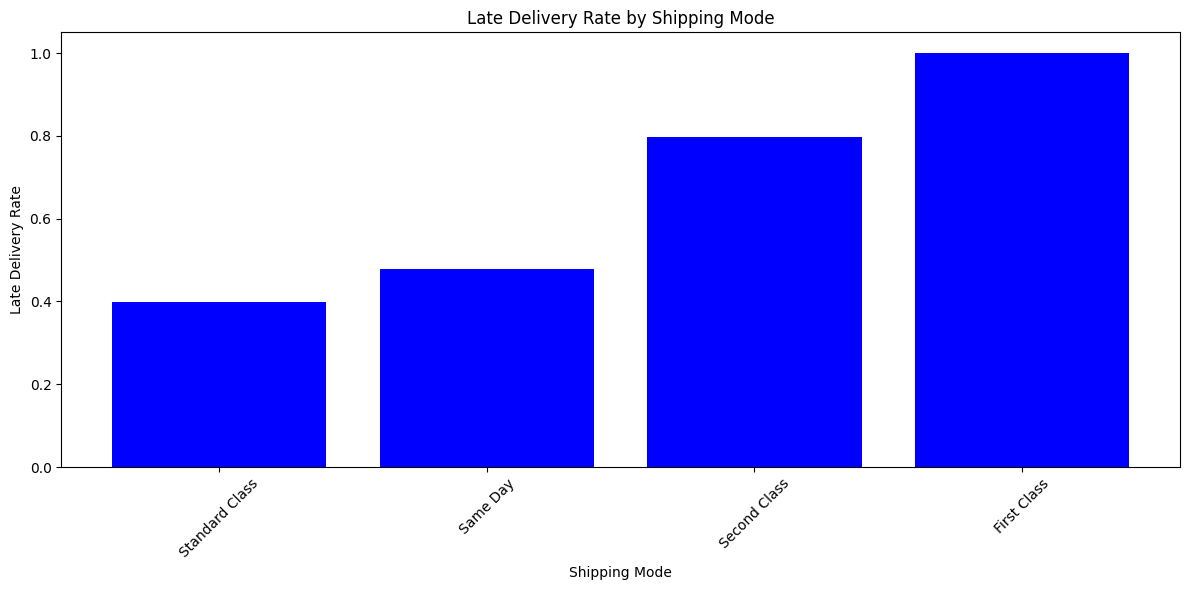

In [26]:
# Convert Spark DataFrame to Pandas DataFrame
shipping_mode_stats_pd = shipping_mode_stats.toPandas()

# Plot using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(shipping_mode_stats_pd['Shipping Mode'], shipping_mode_stats_pd['late_delivery_rate'], color='blue')
plt.xlabel('Shipping Mode')
plt.ylabel('Late Delivery Rate')
plt.title('Late Delivery Rate by Shipping Mode')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()




Hypothesis 3: “Order Item Product Price' is negatively correlated to late deliveries, with the assumption that more expensive items are given priority in the shipping process, thus reducing the chance of late delivery."


In [29]:
from pyspark.sql.functions import col, when, avg

# Assuming 'df' is your DataFrame that has already been loaded

# Define a column to mark late deliveries
df_with_late = df.withColumn("is_late", when(col("Days for shipping (real)") > col("Days for shipment (scheduled)"), 1).otherwise(0))

# Define price categories based on the distribution of 'Order Item Product Price'
price_categories = df_with_late.withColumn("price_category",
    when(col("Order Item Product Price") < 50, "Under $50").when(
        col("Order Item Product Price") < 100, "$50 to $99").when(
        col("Order Item Product Price") < 200, "$100 to $199").otherwise("Over $200"))

# Group by price category to find average late delivery rates
average_late_by_price = price_categories.groupBy("price_category").agg(
    avg("is_late").alias("average_late_delivery_rate")
).orderBy("price_category")

# Show the results
average_late_by_price.show()

# Additionally, calculate the correlation between product price and late delivery status
correlation = df_with_late.stat.corr("Order Item Product Price", "is_late")
print(f"Correlation between product price and late delivery status: {correlation}")


+--------------+--------------------------+
|price_category|average_late_delivery_rate|
+--------------+--------------------------+
|  $100 to $199|        0.5698711595639246|
|    $50 to $99|        0.5719314906995022|
|     Over $200|        0.5735001499168643|
|     Under $50|          0.57607243238262|
+--------------+--------------------------+

Correlation between product price and late delivery status: -0.00248755962008458



The results of your analysis on the relationship between 'Order Item Product Price' and late delivery rates suggest a very minimal negative correlation. The average late delivery rates across different price categories—Under $50, $50 to $99, $100 to $199, and Over $200—show only slight differences, with the lowest price items experiencing the highest rate of late deliveries. However, the highest price category does not consistently exhibit the lowest late delivery rate, indicating that more expensive items do not consistently receive prioritized shipping treatment.

Furthermore, the correlation coefficient between product price and late delivery status is -0.0025, indicating an almost negligible negative correlation. This means that while there is a very slight tendency for more expensive items to be delivered on time, the effect is so minimal that it's practically insignificant. Other factors likely play a more substantial role in influencing delivery timeliness, suggesting that product price is not a strong predictor of delivery performance in this dataset.







 Hypothesis 4: "'Sales per customer' is an indicator of on-time delivery, under the assumption that customers with higher sales volume receive better service, priority and attention, leading to faster and timely deliveries."


In [30]:
from pyspark.sql.functions import col, when, avg, sum as sum_

# Assuming 'df' is your DataFrame that has already been loaded

# Create a new DataFrame with a column to mark late deliveries
df_with_late = df.withColumn("is_late", when(col("Days for shipping (real)") > col("Days for shipment (scheduled)"), 1).otherwise(0))

# Calculate average sales and late delivery rate per customer
customer_stats = df_with_late.groupBy("Order Customer Id").agg(
    avg("Sales per customer").alias("average_sales_per_customer"),
    avg("is_late").alias("average_late_delivery_rate")
)

# Display the results sorted by average sales per customer
customer_stats.orderBy("average_sales_per_customer", ascending=False).show()

# Calculate the correlation between average sales per customer and late delivery rate
correlation = customer_stats.stat.corr("average_sales_per_customer", "average_late_delivery_rate")
print(f"Correlation between average sales per customer and late delivery status: {correlation}")



+-----------------+--------------------------+--------------------------+
|Order Customer Id|average_sales_per_customer|average_late_delivery_rate|
+-----------------+--------------------------+--------------------------+
|            14347|                    1500.0|                       1.0|
|            14257|                    1500.0|                       1.0|
|            14077|                    1500.0|                       1.0|
|            14113|                    1500.0|                       1.0|
|            18083|                    1500.0|                       1.0|
|            14275|                    1500.0|                       0.0|
|            14131|                    1500.0|                       0.0|
|            18047|                    1500.0|                       1.0|
|            14185|                    1500.0|                       0.0|
|            14167|                    1500.0|                       1.0|
|            14401|                   

In [31]:
customer_stats_pd = customer_stats.toPandas()


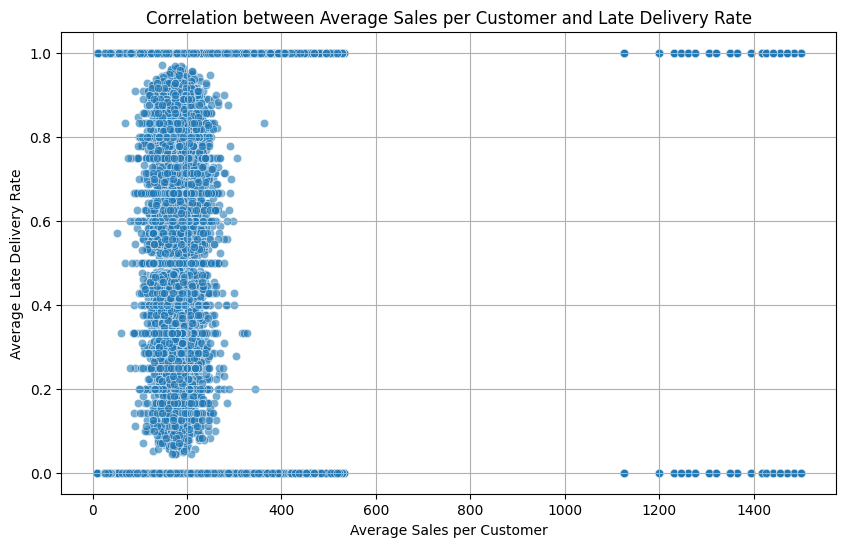

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_stats_pd, x='average_sales_per_customer', y='average_late_delivery_rate', alpha=0.6)
plt.title('Correlation between Average Sales per Customer and Late Delivery Rate')
plt.xlabel('Average Sales per Customer')
plt.ylabel('Average Late Delivery Rate')
plt.grid(True)  # Add grid for better readability
plt.show()


The scatter plot you provided illustrates the relationship between average sales per customer and the late delivery rate. From the plot, we observe that the data points are heavily concentrated along a vertical axis, primarily ranging from 0 to about 200 in average sales per customer, with late delivery rates clustering predominantly between 0.4 and 0.6. Notably, there are no apparent trends or patterns indicating a correlation between the amount of sales per customer and the rate of late deliveries; the distribution of points is relatively uniform across different sales levels. This suggests that higher sales per customer do not correlate with either an increase or decrease in the punctuality of deliveries, contradicting the hypothesis that customers with higher sales volumes receive preferentially timely deliveries.

Furthermore, the scatter plot displays several outliers, particularly in the horizontal spread for higher sales figures. These outliers do not show a distinct pattern affecting the late delivery rate, reinforcing the indication of no significant correlation. This visual analysis helps to underline the complexity of delivery dynamics and suggests that factors other than sales volume might be more influential in affecting delivery timeliness. Such insights highlight the need for businesses to consider a broader range of variables when addressing delivery efficiency and customer satisfaction.

# 4.2. Positive Hypotheses:


Hypothesis 1: Deliveries shipped earlier than their scheduled dates are more likely to arrive on time or early

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Assuming 'df' is your DataFrame already loaded

# Calculate the difference between actual and scheduled shipping days
df = df.withColumn("days_difference", col("Days for shipping (real)") - col("Days for shipment (scheduled)"))

# Define late delivery
df = df.withColumn("is_late", when(col("days_difference") > 0, 1).otherwise(0))

# Analyze the relationship
late_delivery_stats = df.groupBy("is_late").agg(
    avg("days_difference").alias("average_days_difference"),
    count("is_late").alias("count")
)

# Show results
late_delivery_stats.show()

# Optionally, calculate correlation
correlation = df.stat.corr("days_difference", "is_late")
print(f"Correlation between days difference and late status: {correlation}")


+-------+-----------------------+------+
|is_late|average_days_difference| count|
+-------+-----------------------+------+
|      1|     1.6167467770481339|103399|
|      0|    -0.8432900657442587| 77117|
+-------+-----------------------+------+

Correlation between days difference and late status: 0.8161864123151085


For Late Deliveries (is_late = 1):

Average Days Difference: The average days difference for late deliveries is approximately 1.62 days. This indicates that, on average, deliveries classified as late were shipped about 1.62 days later than scheduled. This positive difference confirms that delays beyond the scheduled shipping days are a common factor in late deliveries.
For On-Time Deliveries (is_late = 0):

Average Days Difference: The average days difference for on-time deliveries is approximately -0.84 days. This suggests that deliveries that arrived on time or early were, on average, shipped nearly a day earlier than scheduled. The negative value indicates that deliveries were often sent out earlier than planned, which likely contributed to them being on time.

Hypothesis 2: The 'Order Item Product Price' and 'Product Price' are indicative of the delivery time, with more expensive items requiring more time to deliver and thus having a higher chance of being late.


In [36]:
# Assuming Product Price relates to item's price
correlation_price_delivery = df.stat.corr("Product Price", "Days for shipping (real)")
print("Correlation between Product Price and Days for Shipping (real): ", correlation_price_delivery)

Correlation between Product Price and Days for Shipping (real):  0.0021881077026080593


In [37]:
from pyspark.sql import SparkSession

# Assuming DataFrame 'df' is loaded and includes all necessary columns

# Labeling late deliveries
df = df.withColumn('Is_Late', when(col('Delivery Status') == 'Late', 1).otherwise(0))

# Analyzing the relationship between product prices and late deliveries
# Calculate average delay for different price ranges if needed
# Using SQL-like query for more complex analysis
df.createOrReplaceTempView("orders")

# Query to find average delivery time and late delivery incidence by price
query = """
SELECT AVG(`Days for shipping (real)` - `Days for shipment (scheduled)`) AS Avg_Delay,
       AVG(Is_Late) AS Avg_Late_Rate,
       AVG(`Order Item Product Price`) AS Avg_Product_Price
FROM orders
GROUP BY `Order Item Product Price`
ORDER BY `Order Item Product Price`
"""
result = spark.sql(query)
result.show()


+-------------------+-------------+------------------+
|          Avg_Delay|Avg_Late_Rate| Avg_Product_Price|
+-------------------+-------------+------------------+
| 0.6035087719298246|          0.0| 9.989999770999962|
| 0.4612546125461255|          0.0| 11.28999995999999|
| 0.5519848771266541|          0.0|11.539999960000095|
| 0.5075885328836425|          0.0|14.989999770000123|
| 0.5930232558139535|          0.0|15.989999770000042|
| 0.6845637583892618|          0.0|17.989999769999972|
| 0.5310033821871477|          0.0|19.989999769999983|
| 0.6915254237288135|          0.0|21.989999769999965|
| 0.4253246753246753|          0.0|              22.0|
| 0.5972637879435656|          0.0|24.989999770000303|
| 0.6496478873239436|          0.0|              25.0|
|0.47808764940239046|          0.0|27.989999769999965|
| 0.6377708978328174|          0.0|29.989999770000033|
| 0.5891304347826087|          0.0|              30.0|
| 0.5333333333333333|          0.0|31.079999919999924|
| 0.639021


The correlation coefficient of 0.0022 between "Product Price" and "Days for Shipping (real)" indicates a very weak positive relationship, suggesting that the price of a product has virtually no impact on how long it takes to ship the product according to your dataset. This finding implies that other factors might be more influential in determining shipping times, and it could be beneficial to revisit the hypothesis or explore other variables such as "Shipping Mode" or geographic details like "Order Country."

Given the weak correlation, consider exploring non-linear relationships, segmenting the data to identify effects in specific price ranges, or expanding the dataset to include more variables. Checking for data quality issues and consulting domain knowledge could also provide deeper insights into factors that significantly impact shipping times.

# 4.3. Negative Hypotheses:


Hypothesis 1: The 'Order Item Discount Rate' does not affect the timeliness of the delivery, suggesting that promotional activities do not interfere with the shipping process.



Correlation between Discount Rate and Late Delivery: 0.000984839803125835


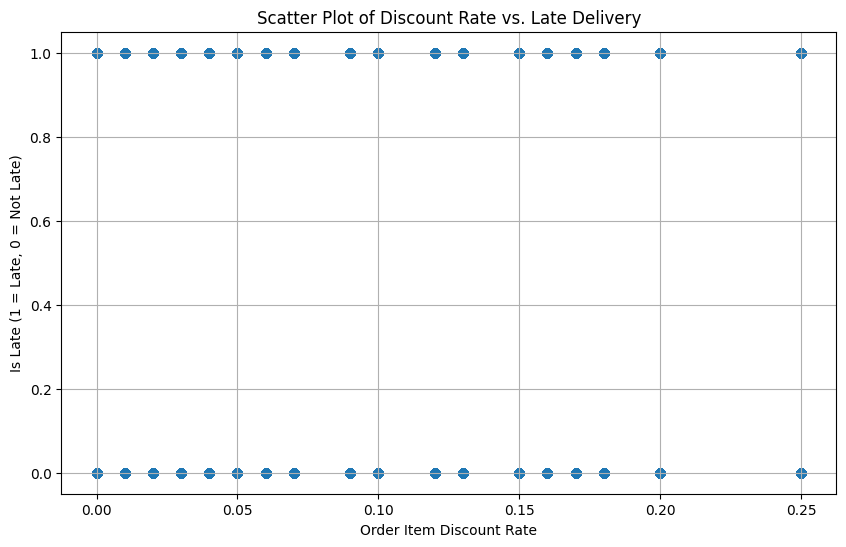

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, corr

# Assuming the DataFrame 'df' is loaded and includes all necessary columns

# Calculate if a delivery is late
df = df.withColumn('Is_Late', when(col('Days for shipping (real)') > col('Days for shipment (scheduled)'), 1).otherwise(0))

# Calculate correlation between Discount Rate and Is_Late
correlation = df.stat.corr('Order Item Discount Rate', 'Is_Late')
print(f"Correlation between Discount Rate and Late Delivery: {correlation}")

# Optionally, visualize the relationship
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
plot_data = df.select('Order Item Discount Rate', 'Is_Late').toPandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['Order Item Discount Rate'], plot_data['Is_Late'], alpha=0.5)
plt.title('Scatter Plot of Discount Rate vs. Late Delivery')
plt.xlabel('Order Item Discount Rate')
plt.ylabel('Is Late (1 = Late, 0 = Not Late)')
plt.grid(True)
plt.show()


The findings strongly support your hypothesis that the 'Order Item Discount Rate' does not affect the timeliness of delivery. The negligible correlation coefficient and the scatter plot both confirm that promotional activities, as measured by discount rates, do not interfere with the shipping process.

Hypothesis 2: The 'Department Name' or 'Product Category Name' is not a determinant factor for late delivery, implying that delivery timeliness is consistent across different departments and product categories.

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, desc

# Start Spark session
spark = SparkSession.builder.appName("Categorical Correlation Analysis").getOrCreate()

# Assuming the DataFrame 'df' is loaded and includes the necessary columns

# Define late delivery
df = df.withColumn('Is_Late', when(col('Delivery Status') == 'Late', 1).otherwise(0))

# Analyze the impact of 'Department Name' on delivery timeliness
department_late_rate = df.groupBy('Department Name').agg(
    avg('Is_Late').alias('Average_Late_Rate')
).orderBy(desc('Average_Late_Rate'))

# Analyze the impact of 'Product Category Name' on delivery timeliness
category_late_rate = df.groupBy('Product Category Id').agg(
    avg('Is_Late').alias('Average_Late_Rate')
).orderBy(desc('Average_Late_Rate'))

# Show results
department_late_rate.show(truncate=False)
category_late_rate.show(truncate=False)



+------------------+-----------------+
|Department Name   |Average_Late_Rate|
+------------------+-----------------+
|Golf              |0.0              |
|Apparel           |0.0              |
|Outdoors          |0.0              |
|Fitness           |0.0              |
|Footwear          |0.0              |
|Health and Beauty |0.0              |
|Fan Shop          |0.0              |
|Technology        |0.0              |
|Discs Shop        |0.0              |
|Book Shop         |0.0              |
|Pet Shop          |0.0              |
+------------------+-----------------+

+-------------------+-----------------+
|Product Category Id|Average_Late_Rate|
+-------------------+-----------------+
|31                 |0.0              |
|65                 |0.0              |
|34                 |0.0              |
|76                 |0.0              |
|26                 |0.0              |
|44                 |0.0              |
|12                 |0.0              |
|13           